In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import MultiIndex, Int64Index

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

C:\Users\86183\AppData\Local\Temp\ipykernel_13528\3064974224.py:5: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\86183\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('../data/PJME_hourly.csv')

In [3]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [4]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

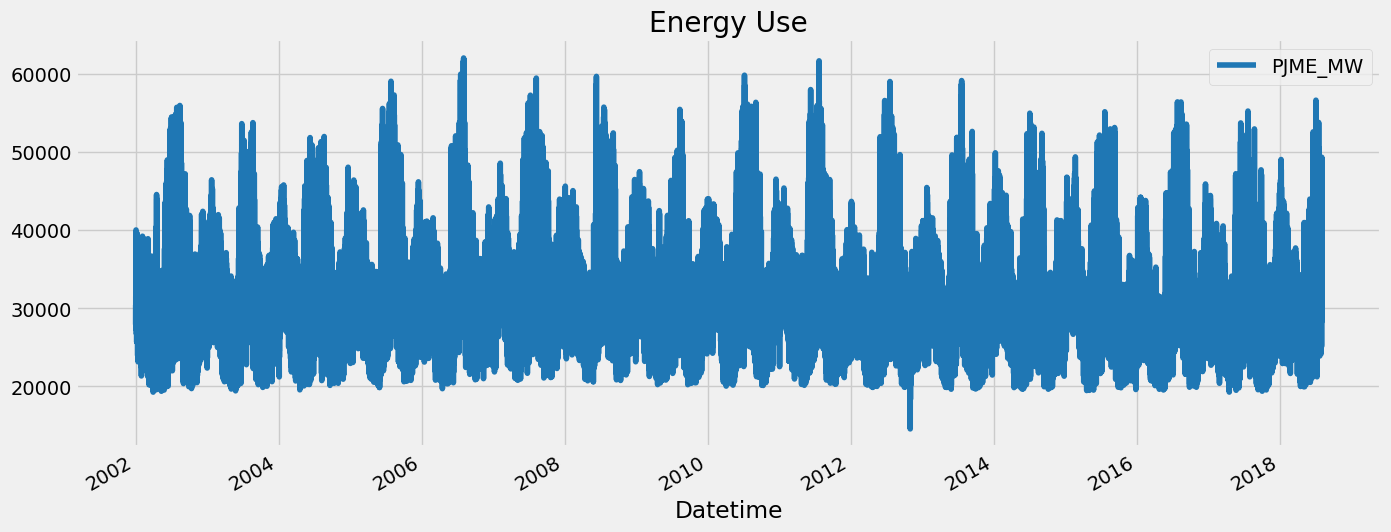

In [5]:
df.plot(figsize=(15, 6),
        color=color_pal[0],
        title='Energy Use')

plt.show()

In [6]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

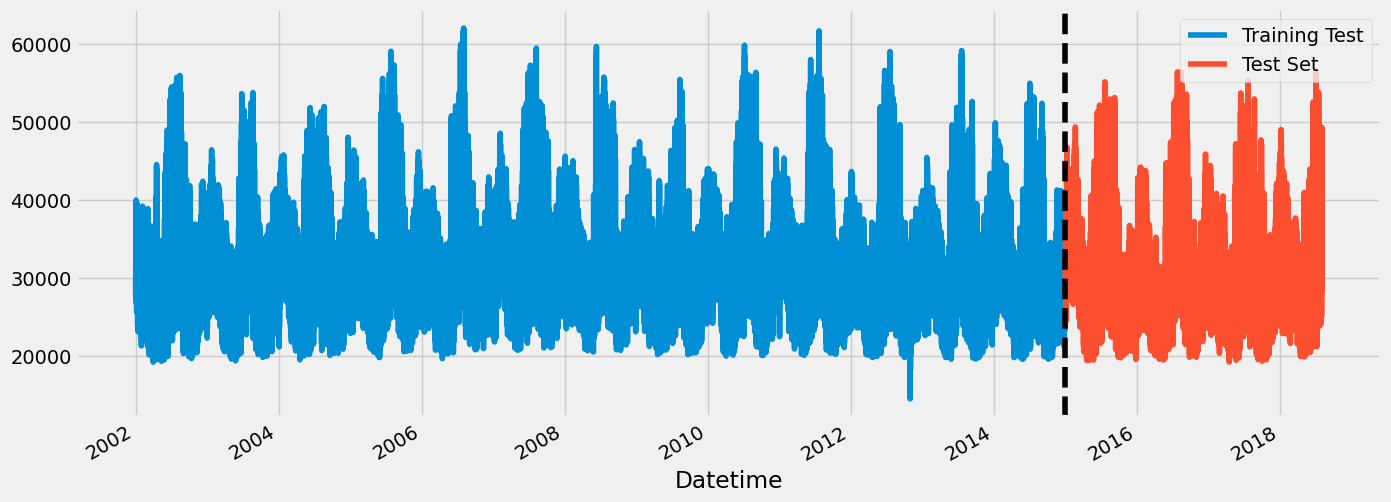

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))

train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Testing Set')

ax.axvline('01-01-2015', color='black', ls='--')

ax.legend(['Training Test', 'Test Set'])
plt.show()

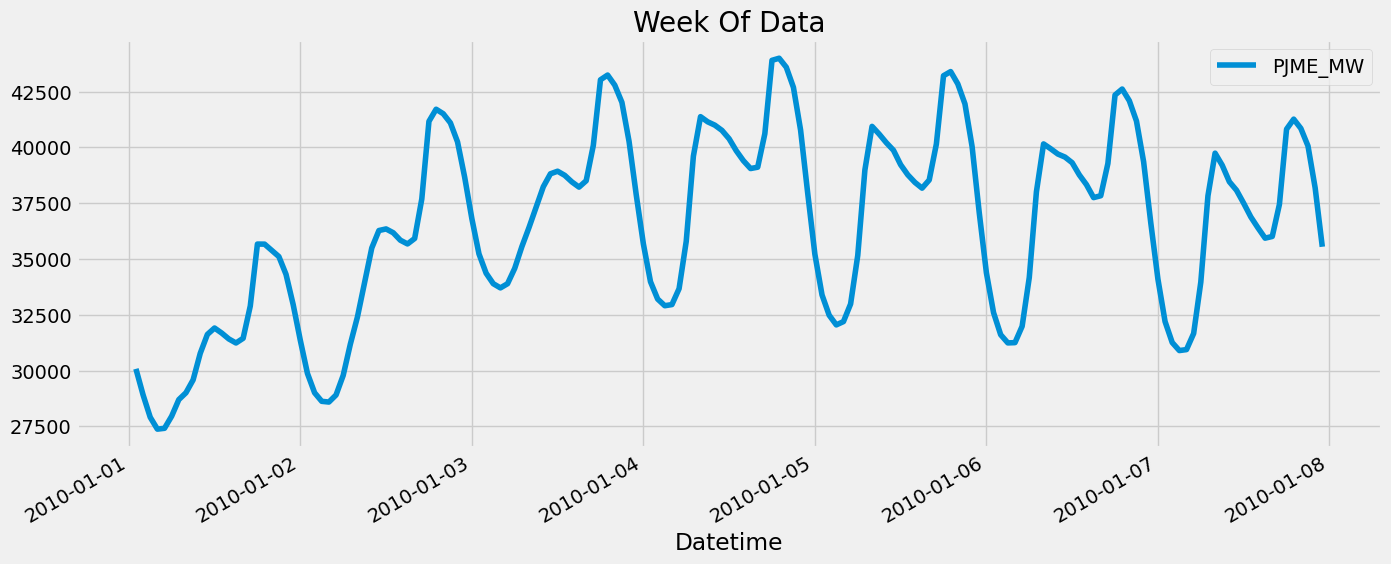

In [8]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 6), title='Week Of Data')

plt.show()

In [9]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [10]:
df = create_features(df)

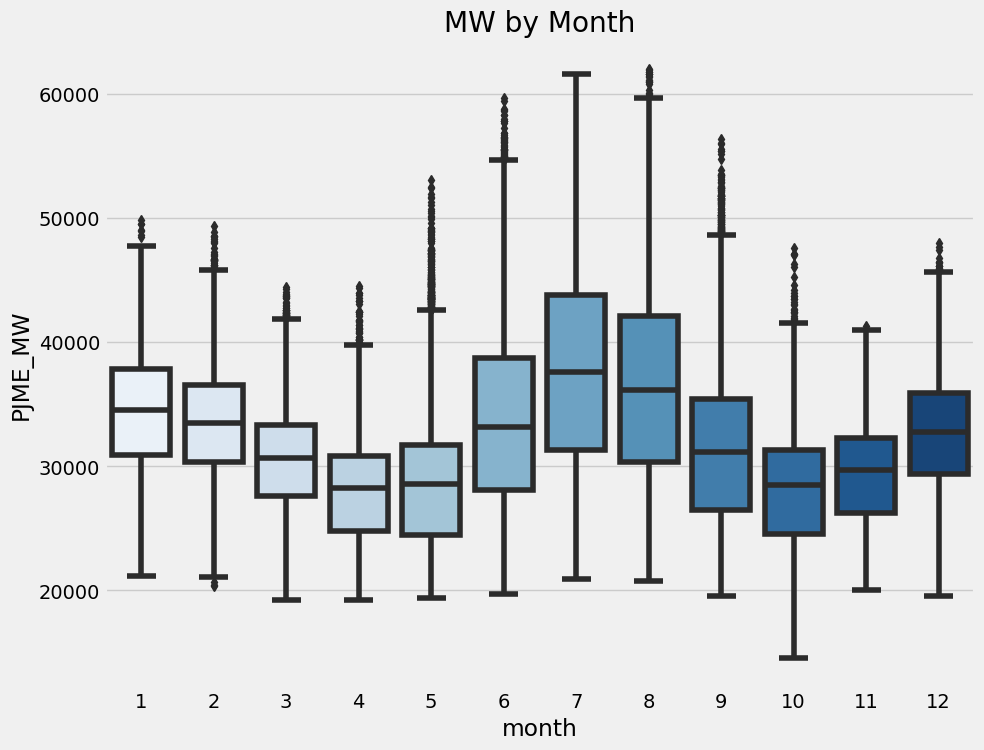

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

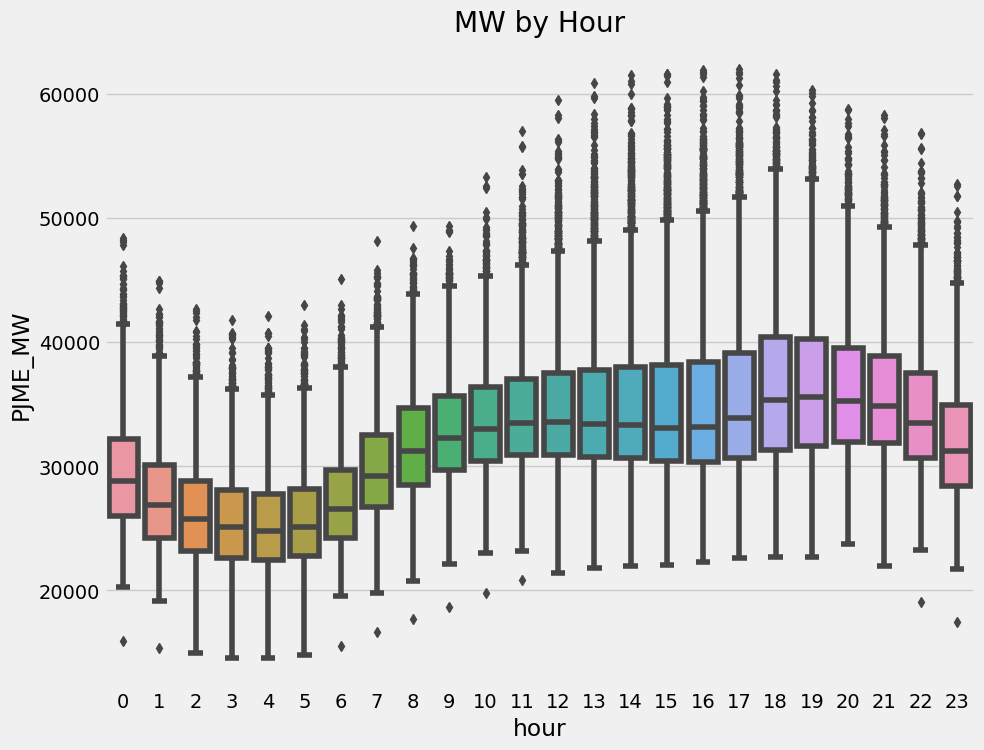

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

In [13]:
train = create_features(train)
test = create_features(test)

In [14]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [15]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [16]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(learning_rate=0.1,
                       booster='gbtree',
                       objective='reg:linear',
                       max_depth=3)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)

[21:36:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29710.39062	validation_1-rmse:28762.54883
[10]	validation_0-rmse:11099.31934	validation_1-rmse:10298.82129


C:\Users\86183\anaconda3\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[20]	validation_0-rmse:5254.74365	validation_1-rmse:4902.53906
[30]	validation_0-rmse:3742.23267	validation_1-rmse:3935.48682
[40]	validation_0-rmse:3375.28198	validation_1-rmse:3831.87183
[50]	validation_0-rmse:3260.28931	validation_1-rmse:3798.55444
[60]	validation_0-rmse:3183.51929	validation_1-rmse:3780.78149
[70]	validation_0-rmse:3134.84375	validation_1-rmse:3766.02515
[80]	validation_0-rmse:3094.81738	validation_1-rmse:3758.22510
[90]	validation_0-rmse:3064.36719	validation_1-rmse:3749.25366
[99]	validation_0-rmse:3044.36743	validation_1-rmse:3739.10718


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [18]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  columns=['importance'])

In [19]:
fi['Feature_Name'] = ['month', 'dayofweek', 'quarter', 'hour', 'year', 'dayofyear']

fi.set_index(['Feature_Name'], inplace=True)

In [20]:
fi.head()

,importance
Feature_Name,
month,0.340484
dayofweek,0.168237
quarter,0.030897
hour,0.288453
year,0.026573


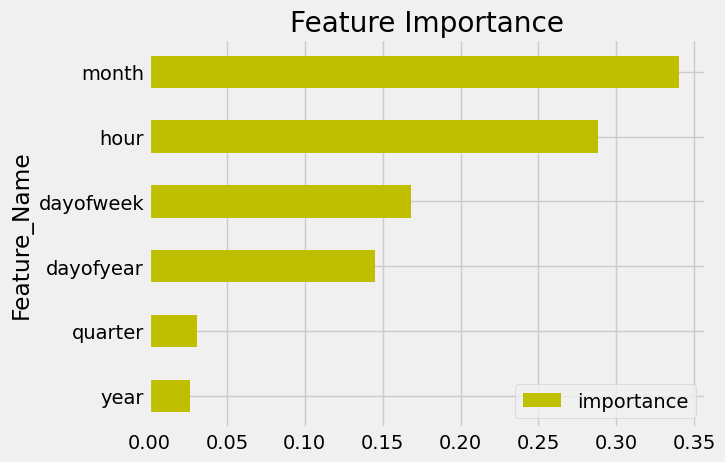

In [21]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', color='y')
plt.show()

In [22]:
test['prediction'] = reg.predict(X_test)

In [23]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,43165.687500
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,42797.257812
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,40915.558594


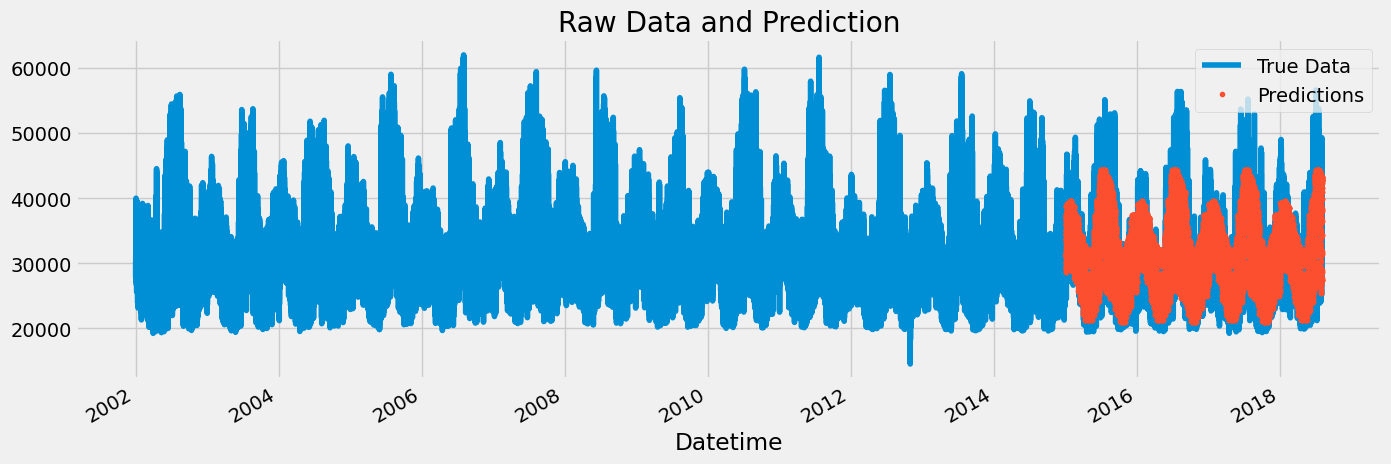

In [24]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))

df['prediction'].plot(ax=ax, style='.')

plt.legend(['True Data', 'Predictions'])

ax.set_title('Raw Data and Prediction')

plt.show()

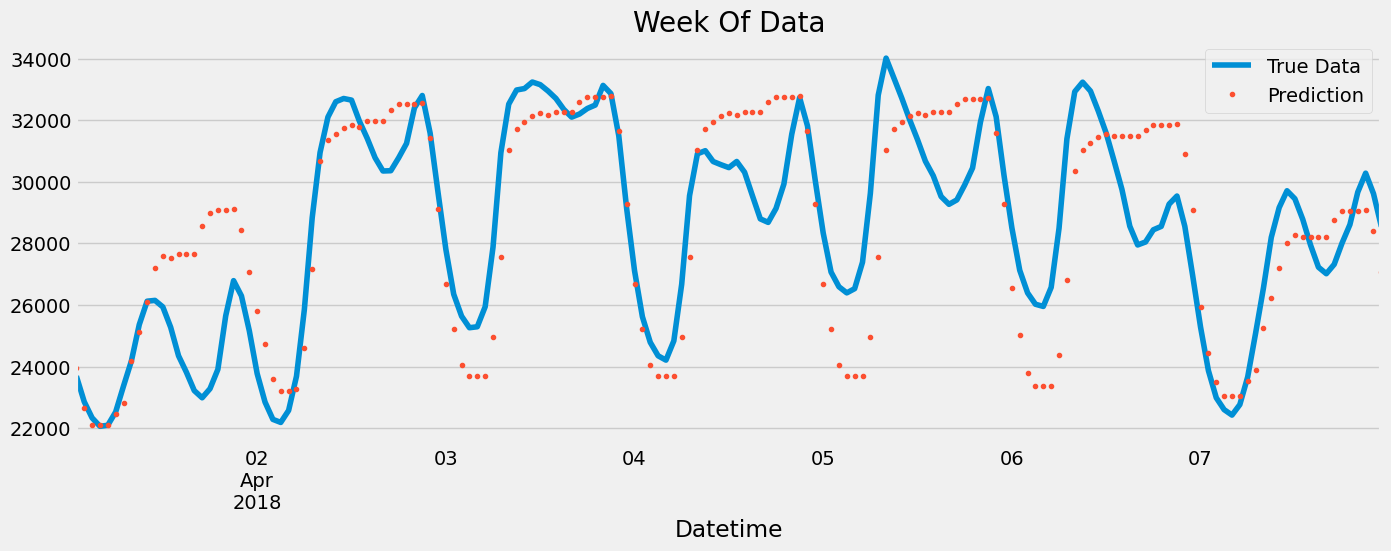

In [25]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data')

df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')

plt.legend(['True Data', 'Prediction'])

plt.show()

In [26]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))

print(score)

3739.1076027835743


In [27]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

test['date'] = test.index.date

In [28]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12977.118164
2016-08-14    12807.382568
2016-09-10    11348.264160
2016-09-09    11163.820231
2015-02-20    10896.245524
2018-01-06    10130.620361
2016-08-12     9752.385661
2017-05-19     9746.389486
2015-02-21     9674.466146
2015-02-16     9634.450602
Name: error, dtype: float64

In [29]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2015-10-28    378.696615
2017-10-24    408.555664
2015-05-06    512.902507
2017-10-15    515.539469
2016-03-20    551.863851
2016-10-27    569.102539
2015-10-09    637.296143
2016-09-16    637.649984
2015-10-03    650.440674
2018-05-16    675.402832
Name: error, dtype: float64